In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
# Make sure we're in the right directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [23]:
import xarray as xr
import numpy as np
from typing import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from aibedo.utilities.plotting import data_snapshots_plotting, data_mean_plotting, zonal_error_plotting
from aibedo.utilities.wandb_api import get_predictions_xarray

In [20]:
predict_set = "same_as_test"  # which data to predict on, can be {<any ESM>, "val", "same_as_test"}, val means the validation-set of the same ESM used for training
test_set = "era5"  # can be 'era5' or 'merra2'. In conjunction with predict_set="same_as_test", predictions will be made on this dataset
DATA_DIR = "./data"  # the data used for prediction must be here, as well as the cmip6 mean/std statistics

overrides = [f'datamodule.num_workers={2}',  # e.g. set to number of CPUs
             f'datamodule.eval_batch_size=10',  # the lower, the less memory will be needed
             f'verbose=False',
             f'datamodule.data_dir={DATA_DIR}',
             f'datamodule.partition=[0.85, 0.15, {test_set}]',  # partition of train, validation, test fractions/sets
             f'++datamodule.prediction_data={predict_set}', 
             f"++model.use_auxiliary_vars=False",  # needs to be True when training only for computation of physics constraints
            ]

In [24]:
predict_xarray_kwargs = dict(
    also_errors=True,   # whether to return errors in the xarray too (bias and MAE if true), formatted as per 'tas_mae', 'tas_pre_bias' etc.
    also_targets=True,  # whether to return the target data (e.g. ERA5 if testing on ERA5), formatted as per 'tas_targets', 'tas_pre_targets' etc.\
    split='predict', 
    variables='all',    # which variable to return predictions for. Can be "all" or any subset of ['pr', 'ps', 'tas']
    return_normalized_outputs=False,  # if true: also return predictions (and targets/errors) for the normalized output variables (with _pre suffix)
)

# Reload and predict with some models:
#### MLP with non-negative preds 

In [30]:
rid_nonneg_pr = "34q3echu"
ds_mlp1 = get_predictions_xarray(rid_nonneg_pr, overrides, **predict_xarray_kwargs)

input_filename is set to compress.isosph.CESM2.historical.r1i1p1f1.Input.Exp8_fixed.nc


In [31]:
ds_mlp1

<xarray.Dataset>
Dimensions:        (snapshot: 756, spatial_dim: 40962)
Coordinates:
    longitude      (spatial_dim) float64 -90.0 -90.0 90.0 ... -22.61 -21.59
    latitude       (spatial_dim) float64 58.28 -58.28 58.28 ... 0.5922 1.773 0.0
  * snapshot       (snapshot) int64 0 1 2 3 4 5 6 ... 750 751 752 753 754 755
Dimensions without coordinates: spatial_dim
Data variables: (12/15)
    tas_preds      (snapshot, spatial_dim) float32 250.8 278.9 ... 300.0 299.6
    tas_targets    (snapshot, spatial_dim) float32 247.3 279.1 ... 299.5 299.1
    tas_bias       (snapshot, spatial_dim) float32 3.473 -0.1951 ... 0.478 0.54
    tas_mae        (snapshot, spatial_dim) float32 3.473 0.1951 ... 0.478 0.54
    tas_mae_score  (snapshot, spatial_dim) float32 0.01305 ... 0.001809
    ps_preds       (snapshot, spatial_dim) float32 1.016e+05 ... 1.01e+05
    ...             ...
    ps_mae_score   (snapshot, spatial_dim) float32 0.002271 ... 0.0002221
    pr_preds       (snapshot, spatial_dim) float32 7.541e-06 ... 2.929e-05
    pr_targets     (snapshot, spatial_dim) float32 6.318e-06 ... 9.51e-06
    pr_bias        (snapshot, spatial_dim) float32 1.222e-06 ... 1.978e-05
    pr_mae         (snapshot, spatial_dim) float32 1.222e-06 ... 1.978e-05
    pr_mae_score   (snapshot, spatial_dim) float32 0.07869 0.1098 ... 0.6363
Attributes:
    description:           ML emulated predictions.
    dataset_name:          ERA5
    variable_names:        tas;ps;pr
    id:                    34q3echu
    ESM_for_training:      CESM2
    physics_loss_weights:  (0, 0, 1000, 1.0, 0.0001)
    time_lag:              0
    icosahedron_order:     6

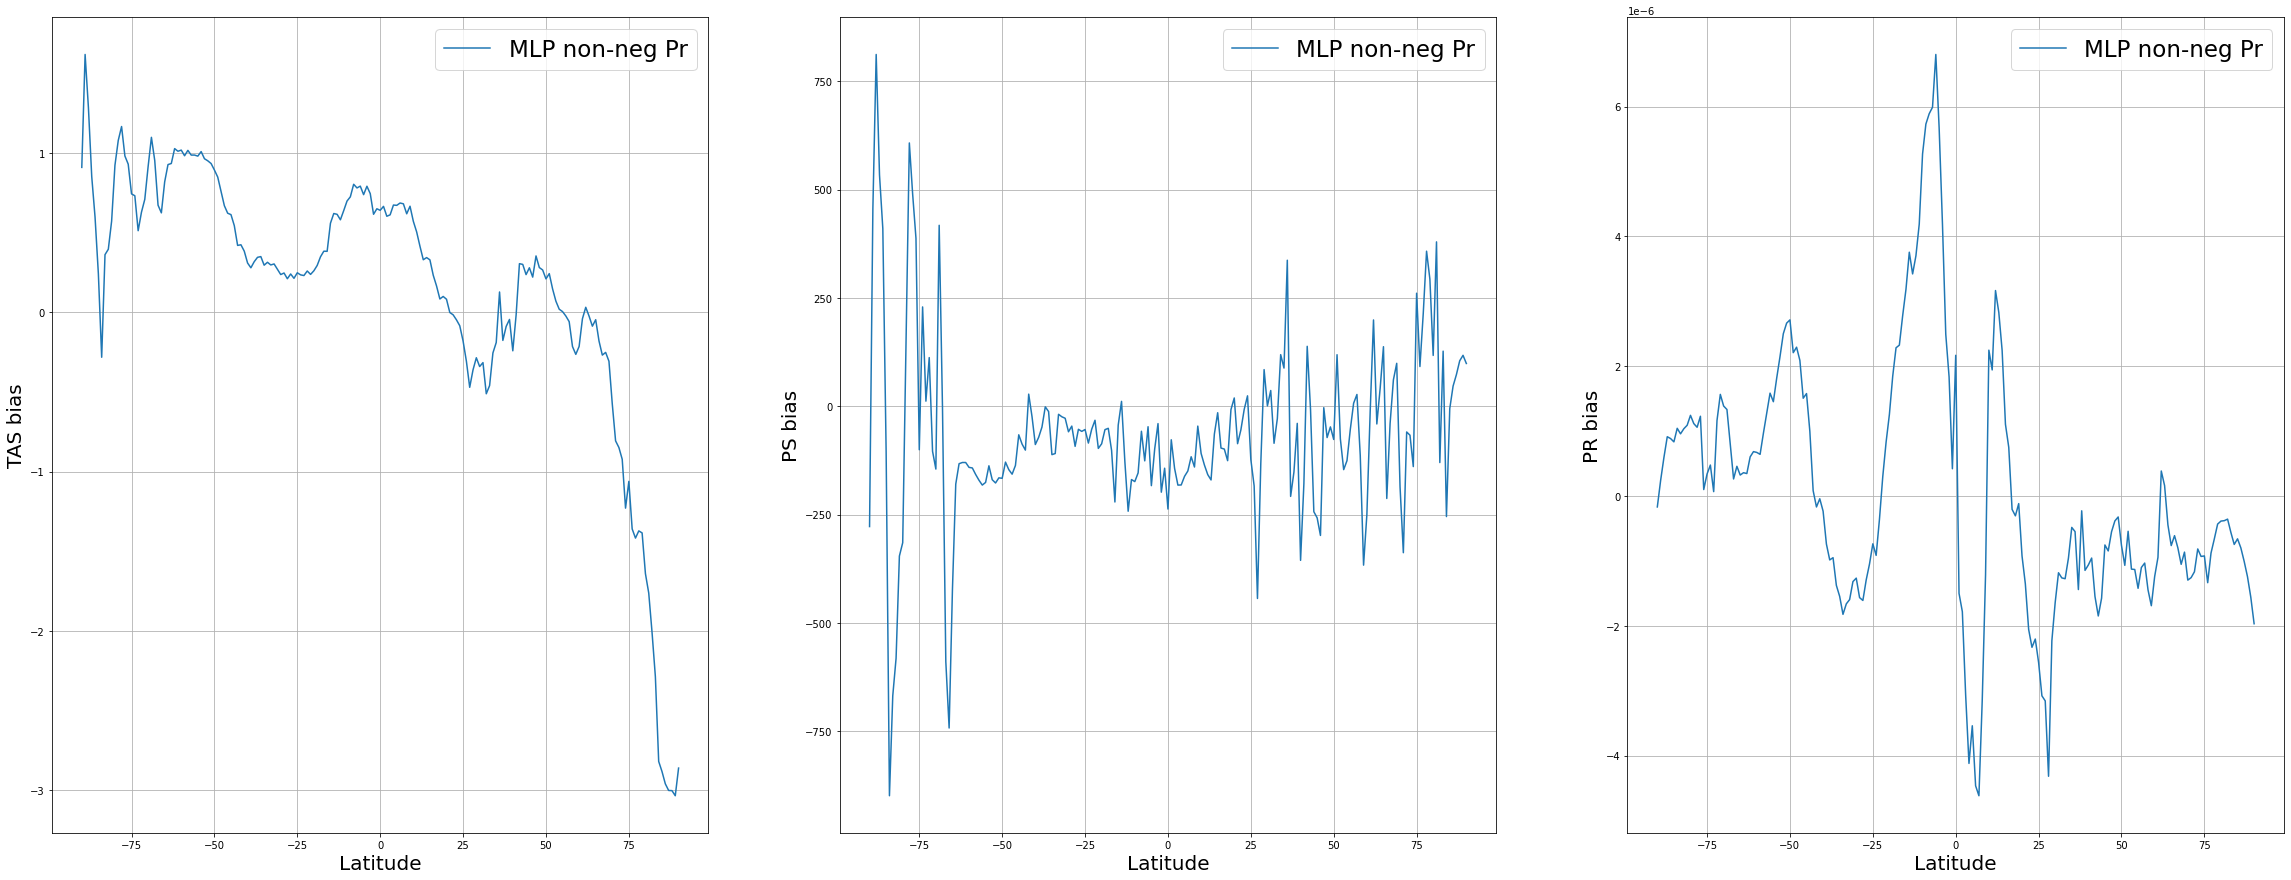

In [29]:
plt.rcParams['figure.figsize'] = [40, 15]  # general matplotlib parameters
_ = zonal_error_plotting(ds_mlp1, labels=["MLP non-neg Pr"], latitude_dim='latitude_grouped', error_to_plot='bias')  # error_to_plot can be 'bias' or 'mae'